# Heat of Formation


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.db import connect
import pandas as pd
con = connect('cubic_perovskites.db')
pt = pd.read_csv('periodic_table_groups.csv', index_col='Symbol')

Inspect the data frame, to understand what it contains

In [2]:
pt

,AtomicNumber,Period,Group,Electronegativity,CovalentRadii,Valence
Symbol,,,,,,
H,1,1,1,2.20,0.31,1
He,2,1,18,NaN,0.28,0
Li,3,2,1,0.98,1.28,1
Be,4,2,2,1.57,0.96,2
B,5,2,13,2.04,0.84,3
C,6,2,14,2.55,0.76,4
N,7,2,15,3.04,0.71,5
O,8,2,16,3.44,0.66,6
F,9,2,17,3.98,0.57,7


In [3]:
import numpy as np

def make_fingerprint(row):
    A = row.A_ion
    B = row.B_ion
    x = []
    
    features = ['AtomicNumber', 'Period', 'Group']  # Initial features to include
    
    # So far, we could also include the following
    features = ['AtomicNumber', 'Period', 'Group', 'Electronegativity', 'CovalentRadii', 'Valence']
    
    # Construct feature vector
    symbols = [A, B]
    x = []
    for feat in features:
        for sym in symbols:
            x.append(pt.loc[sym, feat])
    return np.array(x)

In [4]:
selection = {'combination': 'ABO3'}  # Our selection from the database
n_samples = con.count(**selection)
def make_X():
    '''Make input matrix using ids from database'''
    n_features = len(make_fingerprint(con.get(id=1)))  # Length of input vector
    X = np.zeros((n_samples, n_features))
    
    for ii, row in enumerate(con.select(**selection)):
        X[ii, :] = make_fingerprint(row)
    return X

def make_Y():  
    Y = np.zeros(n_samples)
    for ii, row in enumerate(con.select(**selection)):
        Y[ii] = row.heat_of_formation_all
    return Y

X = make_X()
Y = make_Y()

In [5]:
import sklearn.model_selection as ms
from sklearn.metrics import r2_score, mean_absolute_error
def make_comparison_plot(X, y, model):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    ybar = model.predict(X_test)
    
    n_train, n_test = len(y_train), len(y_test)
    
    r2 = r2_score(y_test, ybar)
    mae = mean_absolute_error(y_test, ybar)
    
    ymax = np.array((y_test, ybar)).max() + 0.1
    ymin = np.array((y_test, ybar)).min() - 0.1
    plt.scatter(ybar, y_test, zorder=0)
    plt.xlim(ymin, ymax)
    plt.ylim(ymin, ymax)
    plt.plot([ymin, ymax], [ymin, ymax], 'k--', zorder=1)
    plt.xlabel('Predicted HOF [eV]')
    plt.ylabel('Actual HOF [eV]')
    plt.title('MAE: {:.3f} eV, $r^2$ score: {:.3f}, trained on: {:d}, tested on: {:d}'.format(mae, r2, n_train, n_test))

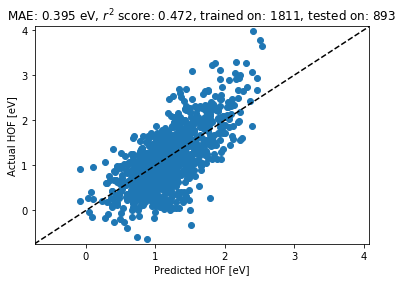

In [6]:
from sklearn import linear_model
linear = linear_model.LinearRegression()
make_comparison_plot(X, Y, linear)

In [7]:
from sklearn.kernel_ridge import KernelRidge
model = KernelRidge(kernel='rbf')

param_grid = {'alpha': np.logspace(-3, 0, 4),
              'gamma': np.logspace(-3, 0, 4)}
gs = ms.GridSearchCV(model, param_grid=param_grid, cv=5,
                     n_jobs=4,  # Set to 1 to disable fitting in parallel
                     verbose=1)

gs.fit(X, Y)
best_params = gs.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   54.6s finished


{'alpha': 0.01, 'gamma': 0.01}


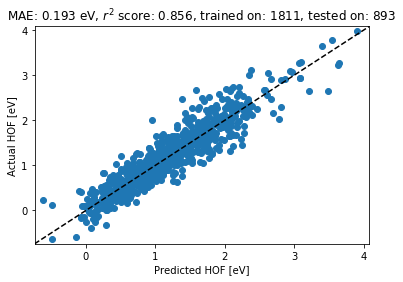

In [8]:
print(best_params)
model.set_params(**best_params)  # Update model to use the best parameters
make_comparison_plot(X, Y, model)